In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from data_analysis.helpers import *

In [15]:
def plotter(
    param_list,
    filters,
    label,
    draw_style,
    test_config,
    topology,
    db,
    metric,
    ax,
    x_variant,
    penalty=False,
):
    param_list = filterParamList(param_list, filters)
    res = getDataFieldSumAvgsAcrossSeeds(
        topology,
        db,
        param_list,
        test_config["source_map_seed"],
        test_config["request_generator_seed"],
        metric,
    )
    if penalty:
        rpen = getDataFieldSumAvgsAcrossSeeds(
            topology,
            db,
            param_list,
            test_config["source_map_seed"],
            test_config["request_generator_seed"],
            "cache_read_penalties",
        )
        wpen = getDataFieldSumAvgsAcrossSeeds(
            topology,
            db,
            param_list,
            test_config["source_map_seed"],
            test_config["request_generator_seed"],
            "cache_write_penalties",
        )
        x_variant = np.sum(rpen + wpen, axis=1)

    if isinstance(x_variant[0], (int,float)):
        ax.plot(x_variant, res, draw_style, fillstyle="none", label=label)
    else:
        ax.plot(list(map(str, x_variant)), res, draw_style, fillstyle="none", label=label)


def plotLooper(
    test_config,
    db,
    case_filters,
    ax,
    experiment_name,
    x_label,
    metric,
    topology,
    cache_pols=None,
    curve_label=None,
    legend=None,
    penalty=False,
):
    param_list = simConfigToParamSets(test_config)
    param_list = filterParamList(param_list, case_filters)

    x_variant = test_config[x_label]
    if isinstance(x_variant[0], list):
        x_variant = list(map(tuple, x_variant))

    if curve_label:
        curve_variant = test_config[curve_label]
        if isinstance(curve_variant[0], list):
            curve_variant = list(map(tuple, curve_variant))
    else:
        curve_variant = []

    if legend is None:
        legend = []
    
    line_styles = {
        "vip": "r^",
        "vipsbw": "b^",
        "vip2": "rv",
        "vipsbw2": "bv",
        "mvip": "rv",
        "palfu": "ks",
        "lfu": "ks",
        "lru": "gx",
        "fifo": "md",
        "unif": "yo",
    }
    dashes = ["-", "--", ":"]

    if cache_pols is None:
        cache_pols = [pol for pol in test_config["cache_pol"]]

    for cache_pol in cache_pols:
        filters = [("cache_pol", cache_pol, None)]
        if curve_variant:
            filters.append(())
            for i, curve in enumerate(curve_variant):
                label = cache_pol + ", " + curve_label + " " + str(curve)
                legend.append(label)
                filters[1] = (curve_label, curve, None)
                plotter(
                    param_list=param_list,
                    filters=filters,
                    label=label,
                    draw_style=dashes[i] + line_styles[cache_pol],
                    test_config=test_config,
                    topology=topology,
                    db=db,
                    metric=metric,
                    ax=ax,
                    x_variant=x_variant,
                    penalty=penalty,
                )
        else:
            label = cache_pol
            legend.append(label)
            plotter(
                param_list=param_list,
                filters=filters,
                label=label,
                draw_style="-" + line_styles[cache_pol],
                test_config=test_config,
                topology=topology,
                db=db,
                metric=metric,
                ax=ax,
                x_variant=x_variant,
                penalty=penalty,
            )

    ax.set_title(experiment_name + " on " + topology)
    if penalty:
        ax.set_xlabel("penalty")
    else:
        ax.set_xlabel(x_label)
    ax.set_ylabel(metric)
    #ax.ticklabel_format(axis="both", style="sci", scilimits=(0, 0), useMathText=True)
    #ax.legend(legend)
    return legend

' experiment_name = "palfu_penalty_seeds"\ntopology = "abilene"\nconfig_path = "../sim_configs/" + experiment_name + "_config.json"\ntest_config = getTestConfig(config_path)\ndb_path = "../sim_outputs/" + experiment_name + "_" + topology + "_db.json"\ndb = getJsonDb(db_path)\nlegend = plotLooper(\n    test_config=test_config,\n    db=db,\n    case_filters=case_filters,\n    ax=ax,\n    experiment_name=experiment_name,\n    x_label="pen_weight",\n    metric="delay",\n    topology=topology,\n    curve_label="cache_capacities",\n    penalty=True,\n    legend=leg\n)\nax.legend(legend) '

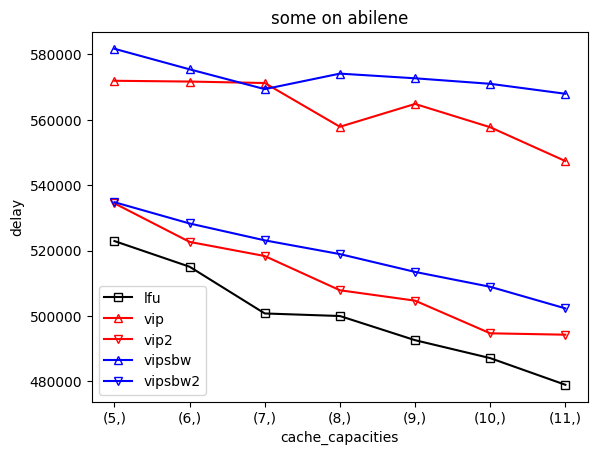

In [17]:
experiment_name = "some"
topology = "abilene"
config_path = "../sim_configs/" + experiment_name + "_config.json"
test_config = getTestConfig(config_path)
db_path = "../sim_outputs/" + experiment_name + "_" + topology + "_db.json"
db = getJsonDb(db_path)

case_filters = [
    #("cache_read_rates", [(25,), (25, 10)], None),
    ("request_dist_param", 0.5, None),
    ("request_rate", 15, None),
    #("num_objects", 1000, None)
]

fig, ax = plt.subplots()
leg = plotLooper(
    test_config=test_config,
    db=db,
    case_filters=case_filters,
    ax=ax,
    experiment_name=experiment_name,
    x_label="cache_capacities",
    metric="delay",
    topology=topology,
    #curve_label="request_dist_param",
    penalty=False,
    cache_pols=["lfu","vip","vip2","vipsbw","vipsbw2"]
)
ax.legend(leg)

""" experiment_name = "palfu_penalty_seeds"
topology = "abilene"
config_path = "../sim_configs/" + experiment_name + "_config.json"
test_config = getTestConfig(config_path)
db_path = "../sim_outputs/" + experiment_name + "_" + topology + "_db.json"
db = getJsonDb(db_path)
legend = plotLooper(
    test_config=test_config,
    db=db,
    case_filters=case_filters,
    ax=ax,
    experiment_name=experiment_name,
    x_label="pen_weight",
    metric="delay",
    topology=topology,
    curve_label="cache_capacities",
    penalty=True,
    legend=leg
)
ax.legend(legend) """